<h1 style="text-align: center;">Fine-Tuning Hubert for Badaga ASR</h1>


*  HuBERT is a self-supervised speech representation model that uses CNN encoder and a Transformer to learn meaningful features from speech audio without labeled data.
* It employs a masked prediction task, where parts of the speech signal are hidden, and the model is trained to predict them.
* To guide learning, an Acoustic Unit Discovery System (e.g., K-means clustering on MFCCs) generates pseudo-labels, which the model uses as training targets. The model iteratively refines these pseudo-labels to improve its representation learning.
* The architecture is given in the following image

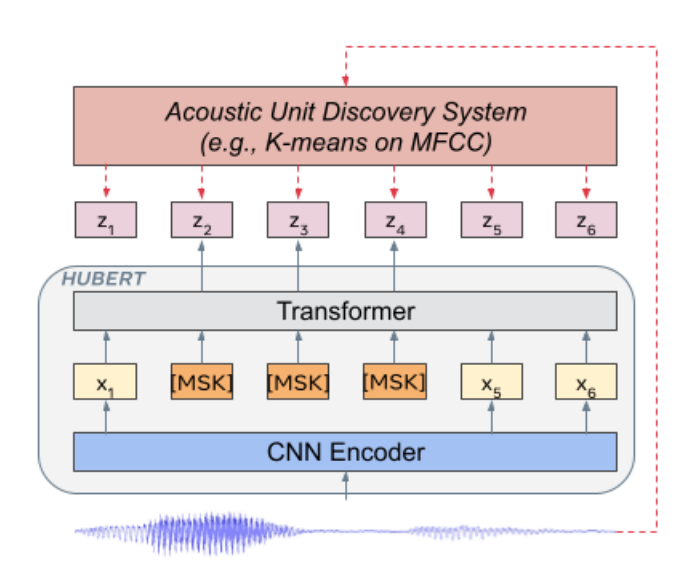


###  Checking GPU Availability

In [14]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.current_device())  # Should show the current GPU index
print(torch.cuda.get_device_name(0))  # Should display the GPU name


True
0
NVIDIA GeForce RTX 3050 Laptop GPU


###  Data Loading and Preprocessing

In [15]:
# Importing the libraries
import os
import pandas as pd
import re
import librosa
from datasets import Dataset

In [16]:
# Define absolute paths
data_directory = r"C:\Users\T H E J\Desktop\Badaga_Corpus-v.0.1.0"
tagged_file = "Badaga-v0.1.0.xlsx"

In [17]:

# joining the path to the root directory
tagged_file_path = os.path.join(data_directory, tagged_file)

# reading the data
data_frame = pd.read_excel(tagged_file_path)

# dropping missing values
data_frame.dropna(inplace=True)

# reading the audio files
data_frame["audio_file_name"] = data_frame["audio_file_name"].apply(lambda x: os.path.join(data_directory, "clips", x))

# splitting the data based on train and test in the transcription file
train_df = data_frame[data_frame["split_label"]!="test"]
test_df = data_frame[data_frame["split_label"]=="test"]

In [18]:
# printing the shape of the train and test
train_df.shape, test_df.shape

((8365, 9), (1469, 9))

### Audio Loading and Dataset Preparation

In [19]:
# loading the audio using librosa 
audio = list()
for file in list(train_df["audio_file_name"]):
    a, s = librosa.load(file, sr=16000)
    audio.append({
        'path': file,
        'array': a,
        'sampling_rate': s
    })
    




audio1 = list()
for file in list(test_df["audio_file_name"]):
    a, s = librosa.load(file, sr=16000)
    audio1.append({
        'path': file,
        'array': a,
        'sampling_rate': s
    })
    



In [20]:
# creating the dictionary for both train and test by taking the audiofile and corresponding translated sentences
train_dict = {'client_id':list(range(0, len(audio))), 'audio': audio, "sentence": list(train_df["translterated_script"])}
test_dict = {'client_id':list(range(len(audio), len(audio)+len(audio1))),'audio': audio1, "sentence": list(test_df["translterated_script"])}

In [21]:
# creating a dataset for the above created dictionary
train_dataset = Dataset.from_dict(train_dict)
test_dataset = Dataset.from_dict(test_dict)

In [22]:
# printing the column names
train_dataset.column_names

['client_id', 'audio', 'sentence']

In [23]:
# printing the first column using index
train_dataset[0]


{'client_id': 0,
 'audio': {'array': [-4.381633131409629e-13,
   -4.547211402989443e-13,
   -3.9910945642124274e-13,
   -3.477597441785274e-13,
   -5.892689764960823e-13,
   -7.35186759560913e-13,
   -1.9754379067867672e-13,
   -6.340125906917349e-13,
   -3.9618181239993444e-13,
   1.3508462469273563e-13,
   -3.499395326463095e-14,
   -4.2430406519029795e-13,
   1.7334330043410062e-13,
   -4.451782367222157e-13,
   -1.756699440861459e-13,
   -4.5253256979356504e-13,
   -8.702850723060762e-13,
   1.7466076870399638e-14,
   1.5608089094180239e-13,
   -5.420372267347928e-13,
   -3.7012819024961896e-13,
   3.2685109501752463e-13,
   -6.801431976215938e-14,
   -3.582878893744479e-13,
   -1.0914449140482507e-13,
   -3.098158936429979e-13,
   -4.894797132719286e-13,
   -6.201866277477652e-13,
   -9.631275811605722e-13,
   -1.0823816615126297e-13,
   -4.2352512013947574e-13,
   -6.471780576722264e-13,
   -7.760326127363715e-14,
   3.445004698177101e-13,
   -4.1060592968246434e-13,
   -9.605296

### Text Cleaning: Removing Special Characters

In [24]:
# function to remove the special characters
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�]'


def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_ignore_regex, '', batch["sentence"]).upper() + " "
    return batch

In [25]:
# removing the special characters from train and test using map function
train_dataset = train_dataset.map(remove_special_characters)
test_dataset = test_dataset.map(remove_special_characters)

Map: 100%|████████████████████████████████████████████████████████████████| 1469/1469 [00:00<00:00, 9259.44 examples/s]


In [26]:
# checking the dataset after removing special characters
train_dataset[0]

{'client_id': 0,
 'audio': {'array': [-4.381633131409629e-13,
   -4.547211402989443e-13,
   -3.9910945642124274e-13,
   -3.477597441785274e-13,
   -5.892689764960823e-13,
   -7.35186759560913e-13,
   -1.9754379067867672e-13,
   -6.340125906917349e-13,
   -3.9618181239993444e-13,
   1.3508462469273563e-13,
   -3.499395326463095e-14,
   -4.2430406519029795e-13,
   1.7334330043410062e-13,
   -4.451782367222157e-13,
   -1.756699440861459e-13,
   -4.5253256979356504e-13,
   -8.702850723060762e-13,
   1.7466076870399638e-14,
   1.5608089094180239e-13,
   -5.420372267347928e-13,
   -3.7012819024961896e-13,
   3.2685109501752463e-13,
   -6.801431976215938e-14,
   -3.582878893744479e-13,
   -1.0914449140482507e-13,
   -3.098158936429979e-13,
   -4.894797132719286e-13,
   -6.201866277477652e-13,
   -9.631275811605722e-13,
   -1.0823816615126297e-13,
   -4.2352512013947574e-13,
   -6.471780576722264e-13,
   -7.760326127363715e-14,
   3.445004698177101e-13,
   -4.1060592968246434e-13,
   -9.605296

### Vocabulary File for CTC Tokenizer (HuBERT)

We have created a JSON vocabulary file (`stt-vocab.json`) to be used with the `Wav2Vec2CTCTokenizer`, which is compatible with **HuBERT fine-tuning** for Automatic Speech Recognition (ASR).  
This file maps characters to integer IDs and is essential for both training and decoding outputs.

---

### Character-Level Vocabulary (For CTC with HuBERT)

The vocabulary includes:

#### 1. **Special Tokens (For CTC and Transformer Decoding)**

| Token     | Description                                                                 |
|-----------|-----------------------------------------------------------------------------|
| `<pad>`   | Padding token — aligns sequences to the same length.                        |
| `<s>`     | Start-of-sentence token — reserved for some transformer architectures.      |
| `</s>`    | End-of-sentence token — similar usage as `<s>`, often not used in CTC.      |
| `<unk>`   | Unknown token — handles unseen or out-of-vocab characters.                  |
| `|`       | Word delimiter token — replaces whitespace during training/inference.       |

#### 2. **Punctuation & Other Symbols**

| Symbol | Purpose                            |
|--------|------------------------------------|
| `'`    | Apostrophes (e.g., in contractions).|
| `-`    | Hyphens in words.                  |

#### 3. **Uppercase Letters A–Z**

- Each uppercase letter (A–Z) is treated as an **independent class/token**.
- During inference, the model outputs sequences of these characters along with `|` to represent spaces between words.

---

### Example Vocabulary JSON

```json
{
  "<pad>": 0,
  "<s>": 1,
  "</s>": 2,
  "<unk>": 3,
  "|": 4,
  "'": 5,
  "-": 6,
  "A": 7,
  "B": 8,
  ...
  "Z": 32
}


### Initializing the HuBERT CTC Tokenizer

We initialize the `Wav2Vec2CTCTokenizer` using a custom vocabulary JSON file (`stt-vocab.json`) for **CTC-based speech recognition** with **HuBERT**.

This tokenizer is designed to map audio-transcribed characters to corresponding integer IDs. It ensures that the output of the HuBERT model aligns with the expected format for decoding.

---

### Special Tokens in Vocabulary

| Token     | Purpose                                                                 |
|-----------|-------------------------------------------------------------------------|
| `<unk>`   | Represents unknown or out-of-vocabulary characters.                     |
| `<pad>`   | Used for padding sequences to the same length during batching.          |
| `|`       | Used as a word separator instead of whitespace.                         |

These tokens are essential for proper training, loss computation, and decoding in CTC-based models like HuBERT.

---

By defining these tokens during tokenizer initialization, we ensure compatibility between the tokenizer and the fine-tuned **HuBERT** model for low-resource language ASR tasks like **Badaga**.


In [27]:
from transformers import Wav2Vec2CTCTokenizer

vocab_file = r"C:\Users\T H E J\Desktop\Badaga_Corpus-v.0.1.0\stt-vocab.json"
tokenizer = Wav2Vec2CTCTokenizer(vocab_file, unk_token="<unk>", pad_token="<pad>", word_delimiter_token="|")

### Creating `Wav2Vec2FeatureExtractor` for HuBERT

The `Wav2Vec2FeatureExtractor` is used to preprocess raw audio input before feeding it into the HuBERT model.

- `feature_size=1`: HuBERT, like Wav2Vec2, processes 1D raw waveform features.
- `sampling_rate=16000`: All audio is resampled to 16kHz, which matches the model’s pretraining.
- `padding_value=0.0`: Padding is applied using zeros to handle varying input lengths.
- `do_normalize=True`: Normalization of audio improves stability and model accuracy.
- `return_attention_mask=True`: Generates attention masks to help the model ignore padded segments — especially useful when training with batches of variable-length audio.

---

In [28]:
# loading the feature extractor for feature extraction
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

###  Using `Wav2Vec2Processor` with HuBERT

* The `Wav2Vec2Processor` seamlessly integrates the **CTC tokenizer** and **feature extractor** into a single interface.
* With HuBERT, this unified processor handles both:
  - **Tokenization** of transcriptions into label IDs for training.
  - **Feature extraction** from raw audio signals.

---

In [29]:
# loading the processor which takes the tokenizer and feature extractor to process
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [30]:
# printing the data after processing 
train_dataset[0]

{'client_id': 0,
 'audio': {'array': [-4.381633131409629e-13,
   -4.547211402989443e-13,
   -3.9910945642124274e-13,
   -3.477597441785274e-13,
   -5.892689764960823e-13,
   -7.35186759560913e-13,
   -1.9754379067867672e-13,
   -6.340125906917349e-13,
   -3.9618181239993444e-13,
   1.3508462469273563e-13,
   -3.499395326463095e-14,
   -4.2430406519029795e-13,
   1.7334330043410062e-13,
   -4.451782367222157e-13,
   -1.756699440861459e-13,
   -4.5253256979356504e-13,
   -8.702850723060762e-13,
   1.7466076870399638e-14,
   1.5608089094180239e-13,
   -5.420372267347928e-13,
   -3.7012819024961896e-13,
   3.2685109501752463e-13,
   -6.801431976215938e-14,
   -3.582878893744479e-13,
   -1.0914449140482507e-13,
   -3.098158936429979e-13,
   -4.894797132719286e-13,
   -6.201866277477652e-13,
   -9.631275811605722e-13,
   -1.0823816615126297e-13,
   -4.2352512013947574e-13,
   -6.471780576722264e-13,
   -7.760326127363715e-14,
   3.445004698177101e-13,
   -4.1060592968246434e-13,
   -9.605296

### Preparing Audio and Transcriptions for HuBERT Training using `Wav2Vec2Processor`
* Finally, we can leverage `Wav2Vec2Processor` to process the data to the format expected by `Wav2Vec2ForCTC` for training. To do so let's make use of Dataset's 'map' function.

* First, we load and resample the audio data, simply by calling `batch["audio"]`.
* Second, we extract the `input_values` from the loaded audio file. In our case, the `Wav2Vec2Processor` only normalizes the data.

* Third, we encode the transcriptions to label ids.

* **Note**: This mapping function is a good example of how the `Wav2Vec2Processor` class should be used. In "normal" context, calling `processor(...)` is redirected to `Wav2Vec2FeatureExtractor`'s call method. When wrapping the processor into the `as_target_processor` context, however, the same method is redirected to `Wav2Vec2CTCTokenizer`'s call method.

In [31]:
# function to pass the audio files in batch
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

In [32]:
# Map function with progress bar
train_dataset = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names, desc="Processing Train Dataset")
test_dataset = test_dataset.map(prepare_dataset, remove_columns=test_dataset.column_names, desc="Processing Test Dataset")


Processing Train Dataset:   0%|                                                        | 0/8365 [00:00<?, ? examples/s]C:\Users\T H E J\anaconda3\envs\gpu_fast\lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Processing Test Dataset: 100%|██████████████████████████████████████████████| 1469/1469 [00:23<00:00, 61.92 examples/s]


### Training Setup

### Set the data collator to handle and pass the data to the model

In [33]:
# defining the function for data collator
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [34]:
# data collator
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

### Defining Evaluation Metrics

In [35]:
# Import the correct metric loading function
import evaluate

# Load Word Error Rate (WER) metric
wer_metric = evaluate.load("wer")


### Function for Evaluation

In [36]:
# function for computing the WER 
import numpy as np
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

## Loading the pre-trained model
* Here we use 'hubert-large-ls960-ft' model.
* **Note: The model needs to be loaded with the HubertForCTC class**.

In [38]:
import torch

# ✅ Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU Available:", torch.cuda.is_available())
print("Using:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

from transformers import HubertForCTC

# ✅ Load the model with ignore_mismatched_sizes=True to fix lm_head size mismatch
model = HubertForCTC.from_pretrained(
    "facebook/hubert-large-ls960-ft",  # or "facebook/hubert-base-ls960"
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
    ignore_mismatched_sizes=True  # ✅ important fix for vocab size mismatch
).to(device)

# ✅ Optional: Freeze the feature extractor and enable gradient checkpointing
model.freeze_feature_extractor()
model.gradient_checkpointing_enable()


GPU Available: True
Using: NVIDIA GeForce RTX 3050 Laptop GPU


Some weights of HubertForCTC were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized because the shapes did not match:
- lm_head.weight: found shape torch.Size([32, 1024]) in the checkpoint and torch.Size([33, 1024]) in the model instantiated
- lm_head.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([33]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\T H E J\anaconda3\envs\gpu_fast\lib\site-packages\transformers\models\hubert\modeling_hubert.py:1429: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [39]:
# setting up the arguments for training
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="hubert-badaga",
  group_by_length=True,
  per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=10,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=3e-4,
  warmup_steps=500,
  save_total_limit=2,
)

C:\Users\T H E J\anaconda3\envs\gpu_fast\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [40]:
# setting up the trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor.feature_extractor,
)

C:\Users\T H E J\AppData\Local\Temp\ipykernel_14664\1840994926.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [41]:
# training 
trainer.train()

Step,Training Loss,Validation Loss,Wer
100,2.895600,2.814524,1.000000
200,2.725600,2.583480,1.000000
300,1.858100,1.333087,0.972458
400,1.426600,0.982347,0.798867
500,1.325900,0.876748,0.662417
600,1.185600,0.871272,0.659270
700,1.280700,0.724591,0.580107
800,1.377000,0.698733,0.535411
900,1.094800,0.766375,0.505194
1000,1.002400,0.702160,0.462071


C:\Users\T H E J\anaconda3\envs\gpu_fast\lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
C:\Users\T H E J\anaconda3\envs\gpu_fast\lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
C:\Users\T H E J\anaconda3\envs\gpu_fast\lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your l

TrainOutput(global_step=10460, training_loss=0.5901506975606569, metrics={'train_runtime': 46305.1296, 'train_samples_per_second': 1.806, 'train_steps_per_second': 0.226, 'total_flos': 6.082338111187655e+18, 'train_loss': 0.5901506975606569, 'epoch': 10.0})